<a href="https://colab.research.google.com/github/prog815/abscur/blob/master/%D0%A1%D0%BE%D1%85%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8_%D0%B7%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%B3%D0%B5%D0%BD%D0%B5%D1%82%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выгрузка и загрузка генетики

**Проект "Абсолютный курс"**

А.В. Енин

г. Оренбург

07.08.2020

Сайт - http://www.abscur.ru

Twitter - https://twitter.com/abscurs

ВКонтакте - https://vk.com/abscur

Одноклассники - https://ok.ru/group/53547043520717

FB - https://www.facebook.com/abscur

Telegram - https://t.me/AbsCur

GitHub - https://github.com/prog815/abscur

WhatsUp - https://chat.whatsapp.com/KrNJXAKizPxDlDSjYfdpQs

Viber - https://invite.viber.com/?g2=AQB63y7Cm%2BNJK0tNZW%2F9kI00M6Wr8HuZ7XeamzN4jZCve8Aq9%2FiD3DY56Eqcf7dc

YouTube - https://www.youtube.com/playlist?list=PLG1V24vhSKo6MamGtgm2oTkDZHeHBHNFW

# Описание

В процессе работы с моделью возникает необходимость выгружать ее на диск.

Здесь тестируем эту возможность.

# Загружаем библиотеку

In [3]:
# ! pip install git+https://github.com/prog815/abscur
# from abscur.optim import ListGenetic

class ListGenetic:
    
    _pop = None
    _diaps = None
    _quality = None
    _hist = None
    _mutate_koef = None
    _quality_method = None

    def __init__(self,pop_size=100,mutate_koef=0.01,quality_method=None,**diaps):
        import numpy as np
        
        self._diaps = diaps
        assert len(diaps) > 0 , "Нет параметров для генетической оптимизации"
        self._pop = np.random.rand(pop_size,len(diaps))
        self._quality = np.zeros((pop_size,))-float('inf')
        self._hist = []
        self._mutate_koef = mutate_koef
        self._quality_method = quality_method
        
    def fit(self,epochs=10):
        import numpy as np
        
        for ep in range(epochs):
            # генерация нового
            new = self._new_genom()

            # расчет качества
            q = self._get_quality(new)

            # замена старого
            n = len(self._hist) % len(self._pop)
            self._pop[n,:] = new
            self._quality[n] = q
            
            # запись истории
            hist_new = { "quality" : q }
            hist_new.update(self._get_gen_params(new))
            
            hist = {"new" : hist_new}

            self._hist.append(hist)

            print(len(self._hist),hist_new)
    
    def _new_genom(self):
        import numpy as np
        
        idxSorted = np.argsort(self._quality)
        idx1,idx2 = np.random.choice(idxSorted[np.round(len(idxSorted))//2:],size=2,replace=False)
        new_genom = self._xver(self._pop[idx1],self._pop[idx2])
        new_genom = self._mutate(new_genom)
        return new_genom

    def _get_quality(self,genom):
        params = self._get_gen_params(genom)
        return self._quality_method(**params)
        

    def _get_gen_params(self,genom):
        import numpy as np

        param_list = list(self._diaps.keys())
        
        def gen2par(g,par_list):
            N = len(par_list)
            idx = int(np.clip(np.round(g*N-0.5),0,N-1))
            return par_list[idx]

        return {key : gen2par(g,self._diaps[key]) for key,g in zip(param_list,genom)}
        
    def _xver(self,genom1,genom2):
        import numpy as np

        new_genom = np.array(genom1)
        for i in range(len(new_genom)):
            if np.random.randn() > 0:
                new_genom[i] = genom1[i]
            else:
                new_genom[i] = genom2[i]
        return new_genom

    def _mutate(self,genom):
        import numpy as np

        new_genom = genom + np.random.randn(len(genom))*self._mutate_koef
        new_genom = np.clip(new_genom,0.,1.)
        return new_genom

    def plot_hist_new(self,params=('quality',)):
        import matplotlib.pyplot as plt
        import numpy as np
        
        def getQM(data,N=20):
            L = len(data)
            dN = L//N
            gl = L//10
            x = list(range(dN,L,dN))
            if x[-1] != L-1:
                x.append(L-1)
            q1 = np.array(x,dtype=float)
            m = np.array(x,dtype=float)
            q2 = np.array(x,dtype=float)
            for i in range(len(x)):
                q1[i],m[i],q2[i] = np.quantile(data[(max(0,x[i]-gl)):(x[i]+1)],(0.1,0.5,0.9))
            return x,q1,m,q2

        for param in params:
            plt.figure(figsize=(10,6))
            v = [h['new'][param] for h in self._hist]
            plt.plot(v,'y.',label='<'+param+'>')
            x,q1,m,q2 = getQM(v)
            plt.plot(x,q2,':',label='q2')
            plt.plot(x,m,'*k-',label='m')
            plt.plot(x,q1,':',label='q1')
            plt.title('параметр <' + param + '>')
            plt.legend()
            plt.show()

# Определяем данные по линейной функции

In [5]:
import numpy as np

N = 1000

X = np.random.randn(N)
Y = np.random.randn(N)

A = 2
B = 4
C = 6

Z = A*X+B*Y+C

Z += np.random.randn(N)*0.1

# Запускаем генетический поиск

## функция оптимизации

In [6]:
def getQualityMethod(a,b,c):
    z = a*X+b*Y+c
    return -np.sum(np.abs(Z-z))

## создание модели генетического поиска

In [5]:
modelGA = ListGenetic(pop_size=20,
                        a=np.arange(-10,10),
                        b=np.arange(-10,10),
                        c=np.arange(-10,10),
                        quality_method=getQualityMethod)

## запуск генетического поиска

In [6]:
modelGA.fit(1000)


1 {'quality': -12642.409709495267, 'a': -9, 'b': 0, 'c': -4}
2 {'quality': -10340.596971828012, 'a': 5, 'b': -8, 'c': 3}
3 {'quality': -13032.70879290145, 'a': 5, 'b': -10, 'c': -1}
4 {'quality': -5944.672884417192, 'a': 5, 'b': -2, 'c': 3}
5 {'quality': -7125.387715932371, 'a': -5, 'b': -1, 'c': 4}
6 {'quality': -4471.406298273463, 'a': 4, 'b': 9, 'c': 5}
7 {'quality': -5299.376142924513, 'a': 5, 'b': -1, 'c': 3}
8 {'quality': -4094.8296350840587, 'a': 5, 'b': 0, 'c': 5}
9 {'quality': -9047.276296003674, 'a': -8, 'b': 9, 'c': 4}
10 {'quality': -4331.4395221323275, 'a': 5, 'b': 0, 'c': 4}
11 {'quality': -7706.177865031443, 'a': 5, 'b': 9, 'c': -1}
12 {'quality': -8240.40831997389, 'a': -6, 'b': -2, 'c': 4}
13 {'quality': -5944.672884417192, 'a': 5, 'b': -2, 'c': 3}
14 {'quality': -5374.399998552687, 'a': 4, 'b': -2, 'c': 4}
15 {'quality': -5171.352613459669, 'a': 4, 'b': -2, 'c': 5}
16 {'quality': -4471.406298273463, 'a': 4, 'b': 9, 'c': 5}
17 {'quality': -4094.8296350840587, 'a': 5, '

## выводим результаты

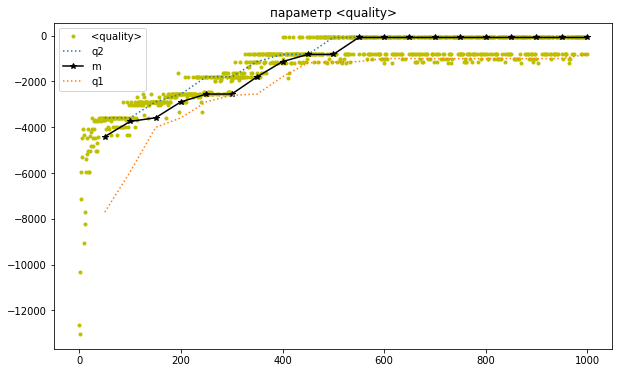

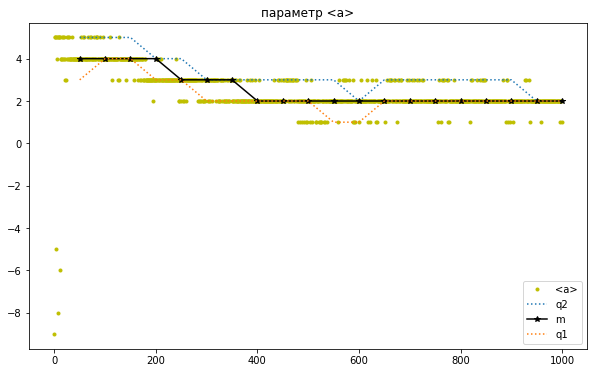

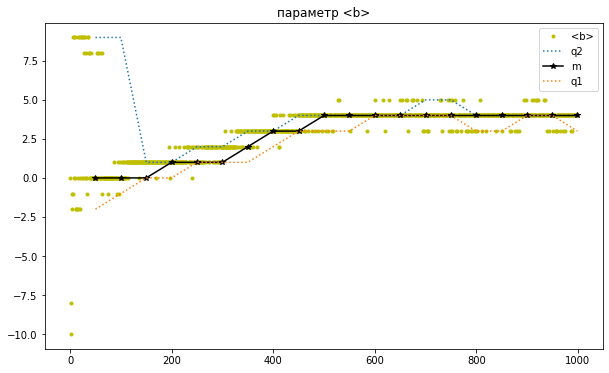

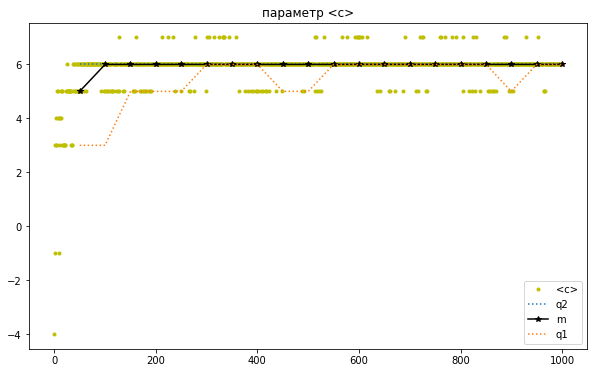

In [7]:
modelGA.plot_hist_new(('quality','a','b','c'))

# Выгрузка модели 

In [1]:
import pickle

In [9]:
with open('model.dat','wb') as file_id:
    pickle.dump(modelGA,file_id,-1)

In [11]:
! ls -l

total 100
-rw-r--r-- 1 root root 94617 Aug  7 12:12 model.dat
drwxr-xr-x 1 root root  4096 Jul 30 16:30 sample_data


# Загрузка модели

## Требования перед загрузкой!!!!!!!!!!!!!!!!!!!

Перед загрузкой должны быть определены:
- class ListGenetic 
- функция getQualityMethod

Иначе при загрузке выдается ошибка. Python требует определение этих двух...

In [7]:
with open('model.dat','rb') as file_id:
    modelGAcopy = pickle.load(file_id)

# Тестируем загруженный код

## гоняем

In [9]:
modelGAcopy.fit()

1011 {'quality': -76.07851390968392, 'a': 2, 'b': 4, 'c': 6}
1012 {'quality': -76.07851390968392, 'a': 2, 'b': 4, 'c': 6}
1013 {'quality': -76.07851390968392, 'a': 2, 'b': 4, 'c': 6}
1014 {'quality': -76.07851390968392, 'a': 2, 'b': 4, 'c': 6}
1015 {'quality': -76.07851390968392, 'a': 2, 'b': 4, 'c': 6}
1016 {'quality': -76.07851390968392, 'a': 2, 'b': 4, 'c': 6}
1017 {'quality': -1150.9231974707423, 'a': 2, 'b': 5, 'c': 7}
1018 {'quality': -76.07851390968392, 'a': 2, 'b': 4, 'c': 6}
1019 {'quality': -1002.4752400182152, 'a': 2, 'b': 4, 'c': 7}
1020 {'quality': -76.07851390968392, 'a': 2, 'b': 4, 'c': 6}


# выводим результаты

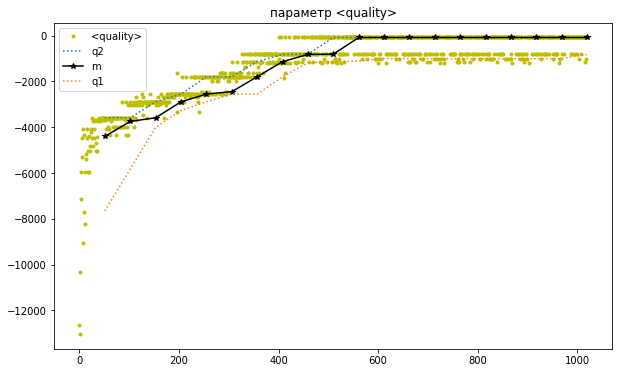

In [10]:
modelGAcopy.plot_hist_new()